In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import datetime
#sns.set(color_codes=True)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import statistics as st
#sns.set_style('whitegrid', {'axes.linewidth' : 0.5})
from statsmodels.distributions.empirical_distribution import ECDF
import scipy
import gc
import collections

import sys
sys.path.append('../prepare_gustav/src/')

from gustav import ebi, ncbi, nlm, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gtfparse import read_gtf
from sklearn.metrics import auc

In [2]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, Circle, EdgesAndLinkedNodes, TapTool, NodesAndLinkedEdges, OpenURL, Title
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap
import networkx as nx

In [3]:
output_notebook()

Loading BokehJS ...

In [323]:
%%time
gene_info = ncbi.gene_info(taxon_ncbi=9606, mode='unambiguous_ensembl')

gene2pubmed = ncbi.gene2pubmed(taxon_ncbi=9606)


ml = ncbi.pubmed(
    'main',
    ['pubmed_id', 'pubdate']   # there are many more columns, including abstracts
).rename(
    columns={'pubdate': 'year'}
).groupby('pubmed_id')['year'].min().reset_index()

gene2pubmed = pd.merge(gene2pubmed, ml, on='pubmed_id', how='left')

../prepare_gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_with_delimiter.drop(column, 1).reset_index(),
../prepare_gustav/src\gustav\utils.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  joined = joined.drop('helper_index', 1)


Wall time: 26.2 s


In [324]:
ensembl_to_ncbi_dict = dict(zip(gene_info['gene_ensembl'], gene_info['gene_ncbi']))
gene_symbol_ncbi_dict = dict(zip(gene_info['symbol_ncbi'], gene_info['gene_ncbi']))
nomenclature_ncbi_dict = dict(zip(gene_info['full_name_from_nomenclature_authority'], gene_info['gene_ncbi']))

In [325]:
%%time
# whole network

gene2pubmed_new = gene2pubmed.copy()

valid_pubmed_ids = gene2pubmed_new['pubmed_id'].value_counts()

valid_pubmed_ids = valid_pubmed_ids[(valid_pubmed_ids > 1) & (valid_pubmed_ids <= 10)]

gene2pubmed_new = gene2pubmed_new[gene2pubmed_new['pubmed_id'].isin(valid_pubmed_ids.index)]

gene_count = gene2pubmed[(gene2pubmed['year'] <= 2018)]['gene_ncbi'].value_counts()

genes_of_interest = gene_count[(gene_count.keys().isin(gene_info['gene_ncbi']))].index.values

Wall time: 547 ms


In [326]:
%%time
edge_df = gene2pubmed_new[gene2pubmed_new['gene_ncbi'].isin(genes_of_interest)][['gene_ncbi', 'pubmed_id']]
G = nx.from_edgelist(edge_df.values)

#len(edge_df['gene_ncbi'].value_counts().index.values)

node_list = [int(node) for node in edge_df['gene_ncbi'].value_counts().index.values]

B_weighted = nx.algorithms.bipartite.weighted_projected_graph(G, nodes=node_list)

#B_weighted.add_nodes_from([int(node) for node in list(set(genes_of_interest) - set(B_weighted.nodes))])

G = B_weighted

Wall time: 31.9 s


In [299]:
gene2go = ncbi.gene2go(taxon_ncbi='9606')
gene2go = gene2go.drop_duplicates(['gene_ncbi', 'go_term'])

../prepare_gustav/src\gustav\ncbi.py:157: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df['_merge'] == 'left_only', :].drop('_merge', 1)


In [63]:
gene_count_dict = gene_count.to_dict()

In [78]:
%%time
ontology = set(gene2go[gene2go['go_term'] == 'regulation of complement activation']['gene_ncbi'].value_counts().index.values)
#pn = set(pn_df['gene_ncbi'].values)
result_df = pd.DataFrame({'gene_ncbi':[], 'n_neighbors':[], 'overlap_with_ontology':[], 'in_ontology':[]})
for node in list(G.nodes):
    neighbor_set = set(G[node])
    result_df = result_df.append(pd.DataFrame({'gene_ncbi':[node], 
                                              'n_neighbors':[len(neighbor_set)], 
                                              'overlap_with_ontology':[len(neighbor_set & ontology)], 
                                               'in_ontology':[bool(node in ontology)], 'n_pubs':[gene_count_dict.get(node)]}))
    
result_df['in_ontology'] = result_df['in_ontology'].astype(bool)

Wall time: 25 s


In [80]:
size_of_pn = len(set(G.nodes) & ontology)
universe_size = len(set(G.nodes))

p = 1-scipy.stats.hypergeom.cdf(M=universe_size, 
                                N=result_df['n_neighbors'], 
                                n=size_of_pn, k=result_df['overlap_with_ontology']-1)

result_df['p'] = p

bh_fdr = p*len(p)/(scipy.stats.rankdata(p))
bh_fdr[bh_fdr > 1.0] = 1.0 # no q-values above 1.0!

bonferroni = p*len(p)
bonferroni[bonferroni > 1.0] = 1.0

result_df['fdr'] = bh_fdr
result_df['fwer'] = bonferroni
result_df['exp_val'] = result_df['n_neighbors'] * size_of_pn / universe_size
result_df['ratio'] = result_df['overlap_with_ontology']/result_df['exp_val']

auroc: 0.7712039915608851
Wall time: 117 ms


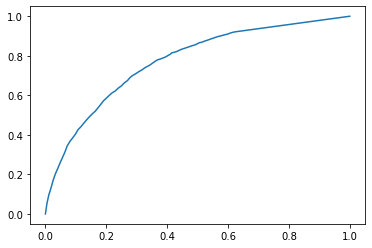

In [170]:
%%time
n = 100
prior = result_df['p'].rank(pct=True)
actual_set = result_df['in_ontology']
roc_tpr = []
roc_fpr = []
for ii in np.arange(0,1+0.5/n,1/n):
    predicted_set = np.array(prior < ii)
    tp = np.sum(predicted_set & actual_set)
    fn = np.sum((~predicted_set) & actual_set)
    tn = np.sum((~predicted_set) & (~actual_set))
    fp = np.sum((predicted_set) & (~actual_set))
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
auroc = auc(roc_fpr, roc_tpr)
print('auroc: ' + str(auroc))
plt.plot(roc_fpr, roc_tpr)

In [139]:
go_list = gene2go['go_id'].value_counts()[0:500].index.values

In [129]:
%%time
# getting the founding dates of top 500 GO terms
go_origin_dates = {}
for go_term in go_list:
    r = requests.get('https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/' + go_term + '/complete', auth=('user', 'pass'))
    json_response = r.json()
    history = pd.DataFrame(json_response['results'][0]['history'])
    origin_str = history[(history['action'] == 'Added') & 
                         (history['category'] == 'TERM')].sort_values('timestamp')['timestamp'].values[0]
    go_origin_dates[go_term] = origin_str

Wall time: 4min 54s


In [142]:
pd.DataFrame.from_dict(go_origin_dates, orient='index').sort_values(0)

,0
GO:0005515,2001-03-30
GO:0005770,2001-03-30
GO:0016491,2001-03-30
GO:0008283,2001-03-30
GO:0006629,2001-03-30
...,...
GO:0098978,2016-06-15
GO:0097711,2016-08-07
GO:0098685,2017-02-08
GO:0062023,2018-04-15


In [143]:
gene2go

,gene_ncbi,go_id,evidence,qualifier,go_term,pubmed_ids,category,taxon_ncbi
0,1,GO:0002576,TAS,-,platelet degranulation,-,Process,9606
2,1,GO:0005576,HDA,-,extracellular region,27068509,Component,9606
5,1,GO:0005615,HDA,-,extracellular space,16502470,Component,9606
7,1,GO:0031093,TAS,-,platelet alpha granule lumen,-,Component,9606
8,1,GO:0034774,TAS,-,secretory granule lumen,-,Component,9606
...,...,...,...,...,...,...,...,...
333314,113523636,GO:0016021,IEA,-,integral component of membrane,-,Component,9606
333315,113523639,GO:0016021,IEA,-,integral component of membrane,-,Component,9606
333316,113839518,GO:0005730,IEA,-,nucleolus,-,Component,9606
333317,113839518,GO:0006396,IEA,-,RNA processing,-,Process,9606


In [171]:
%%time
auroc_p = {}
true_ontology_size = {}
network_ontology_size = {}
number_of_terms = 300

for go_id, ii in zip(go_list[0:number_of_terms], range(number_of_terms)):
    ontology = set(gene2go[gene2go['go_id'] == go_id]['gene_ncbi'].value_counts().index.values)
    #pn = set(pn_df['gene_ncbi'].values)
    result_df = pd.DataFrame({'gene_ncbi':[], 'n_neighbors':[], 'overlap_with_ontology':[], 'in_ontology':[]})
    for node in list(G.nodes):
        neighbor_set = set(G[node])
        result_df = result_df.append(pd.DataFrame({'gene_ncbi':[node], 
                                                  'n_neighbors':[len(neighbor_set)], 
                                                  'overlap_with_ontology':[len(neighbor_set & ontology)], 
                                                   'in_ontology':[bool(node in ontology)], 'n_pubs':[gene_count_dict.get(node)]}))

    result_df['in_ontology'] = result_df['in_ontology'].astype(bool)
    
    size_of_pn = len(set(G.nodes) & ontology)
    
    true_ontology_size[go_id] = len(ontology)
    network_ontology_size[go_id] = size_of_pn
    
    universe_size = len(set(G.nodes))

    p = 1-scipy.stats.hypergeom.cdf(M=universe_size, 
                                    N=result_df['n_neighbors'], 
                                    n=size_of_pn, k=result_df['overlap_with_ontology']-1)

    result_df['p'] = p

    bh_fdr = p*len(p)/(scipy.stats.rankdata(p))
    bh_fdr[bh_fdr > 1.0] = 1.0 # no q-values above 1.0!

    bonferroni = p*len(p)
    bonferroni[bonferroni > 1.0] = 1.0

    result_df['fdr'] = bh_fdr
    result_df['fwer'] = bonferroni
    result_df['exp_val'] = result_df['n_neighbors'] * size_of_pn / universe_size
    result_df['ratio'] = result_df['overlap_with_ontology']/result_df['exp_val']
    
    print(go_id + ' (' + str(ii+1) + ')')
    n = 100
    prior = result_df['p'].rank(pct=True)
    actual_set = result_df['in_ontology']
    roc_tpr = []
    roc_fpr = []
    for ii in np.arange(0,1+0.5/n,1/n):
        predicted_set = np.array(prior < ii)
        tp = np.sum(predicted_set & actual_set)
        fn = np.sum((~predicted_set) & actual_set)
        tn = np.sum((~predicted_set) & (~actual_set))
        fp = np.sum((predicted_set) & (~actual_set))
        tpr = tp/(tp + fn)
        fpr = fp/(fp + tn)
        roc_tpr.append(tpr)
        roc_fpr.append(fpr)
    auroc = auc(roc_fpr, roc_tpr)
    print('AUROC (p-value): ' + str(auroc))
    auroc_p[go_id] = auroc

GO:0005515 (1)
AUROC (p-value): 0.844884003157518
GO:0005634 (2)
AUROC (p-value): 0.840915580963491
GO:0005829 (3)
AUROC (p-value): 0.8352281856488339
GO:0005737 (4)
AUROC (p-value): 0.7717308011490347
GO:0005886 (5)
AUROC (p-value): 0.8567803460435386
GO:0005654 (6)
AUROC (p-value): 0.8500390811423488
GO:0016021 (7)
AUROC (p-value): 0.8174957781687356
GO:0046872 (8)
AUROC (p-value): 0.7681770621145445
GO:0070062 (9)
AUROC (p-value): 0.8154335590110361
GO:0016020 (10)
AUROC (p-value): 0.7712039915608851
GO:0005576 (11)
AUROC (p-value): 0.8567949809156005
GO:0005615 (12)
AUROC (p-value): 0.8767644501369329
GO:0005524 (13)
AUROC (p-value): 0.8533457059176655
GO:0003723 (14)
AUROC (p-value): 0.8637173245214123
GO:0005887 (15)
AUROC (p-value): 0.9035777474840183
GO:0042802 (16)
AUROC (p-value): 0.7687373714207945
GO:0005730 (17)
AUROC (p-value): 0.8065075565855847
GO:0003677 (18)
AUROC (p-value): 0.8304102840428775
GO:0005739 (19)
AUROC (p-value): 0.8134141238713506
GO:0045944 (20)
AUROC (

GO:0070374 (158)
AUROC (p-value): 0.8888264469782804
GO:0004672 (159)
AUROC (p-value): 0.919385409826279
GO:0034220 (160)
AUROC (p-value): 0.965039455073327
GO:0005929 (161)
AUROC (p-value): 0.8627762846489732
GO:0043235 (162)
AUROC (p-value): 0.8837324387854646
GO:0007601 (163)
AUROC (p-value): 0.8638172371058611
GO:0003735 (164)
AUROC (p-value): 0.9047097137608923
GO:0001701 (165)
AUROC (p-value): 0.7373578040286398
GO:0016323 (166)
AUROC (p-value): 0.8793451069164258
GO:0051015 (167)
AUROC (p-value): 0.8934888393190035
GO:0042742 (168)
AUROC (p-value): 0.8845973555572963
GO:0005516 (169)
AUROC (p-value): 0.8958486437641124
GO:0003729 (170)
AUROC (p-value): 0.8879090872820904
GO:0042981 (171)
AUROC (p-value): 0.8850652126954333
GO:0051607 (172)
AUROC (p-value): 0.9077792990105742
GO:0003676 (173)
AUROC (p-value): 0.6516972490166659
GO:0016055 (174)
AUROC (p-value): 0.9157747658451921
GO:0050900 (175)
AUROC (p-value): 0.9363529094709854
GO:0030054 (176)
AUROC (p-value): 0.749861212521

In [194]:
auroc_df = pd.DataFrame({'go_id':go_list, 
              'auroc_p':[auroc_p.get(go_id) for go_id in go_list], 
              'true_ontology_size':[true_ontology_size.get(go_id) for go_id in go_list], 
              'network_ontology_size':[network_ontology_size.get(go_id) for go_id in go_list], 
                         'first_added':[go_origin_dates.get(go_id) for go_id in go_list]}).dropna()
auroc_df = pd.merge(auroc_df, gene2go[['go_id', 'go_term', 'category']].drop_duplicates(), how='left')

In [241]:
auroc_df['first_added'] = pd.to_datetime(auroc_df['first_added'])

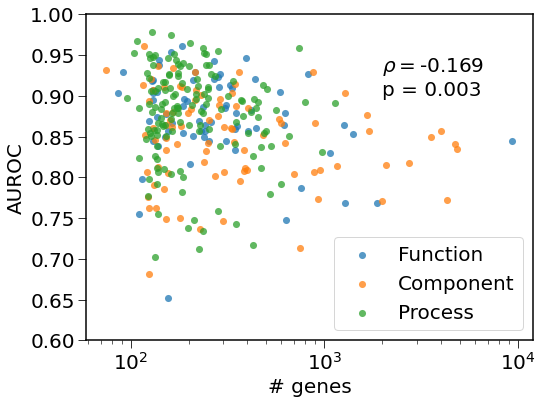

In [346]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
for cat in ['Function', 'Component', 'Process']:
    auroc_df_slice = auroc_df[auroc_df['category'] == cat]
    ax.scatter(auroc_df_slice['network_ontology_size'], auroc_df_slice['auroc_p'], 
               label=cat, s=50, alpha=0.75, linewidth=0)
ax.set_xscale('log')
ax.set_ylim([0.60,1.00])
for ax in [plt.gca()]:
    ax.tick_params(axis='both', labelsize=20)
    ax.tick_params(which='minor', length=4)
    ax.tick_params(which='major', length=8)
    #ax.grid()
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1.5)
        ax.spines[pos].set_color('k')
leg = ax.legend(fontsize=20, frameon=True)
ax.set_ylabel('AUROC', fontsize=20)
ax.set_xlabel('# genes', fontsize=20)
rho, p = scipy.stats.spearmanr(auroc_df['network_ontology_size'], auroc_df['auroc_p'])
ax.text(s=r'$\rho = $' + "{:.3f}".format(rho) + '\n' + 'p = ' + "{:.3f}".format(p), y=0.9, x=2000, fontsize=20)
plt.savefig('./img/auroc_versus_ontology_size.png', bbox_inches='tight', dpi=200)

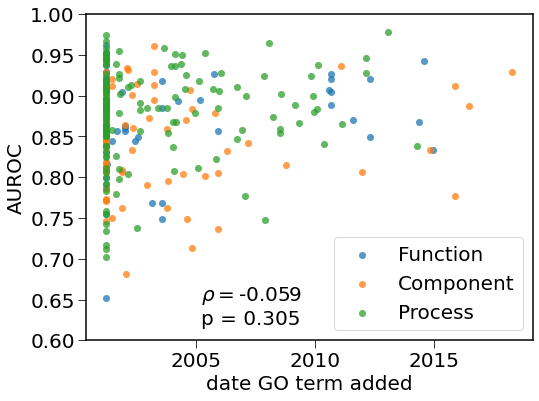

In [347]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
for cat in ['Function', 'Component', 'Process']:
    auroc_df_slice = auroc_df[auroc_df['category'] == cat]
    ax.scatter(auroc_df_slice['first_added'], auroc_df_slice['auroc_p'], label=cat, s=50, alpha=0.75, linewidth=0)
#ax.set_xscale('log')
ax.set_ylim([0.60,1.00])
for ax in [plt.gca()]:
    ax.tick_params(axis='both', labelsize=20)
    ax.tick_params(which='minor', length=4)
    ax.tick_params(which='major', length=8)
    #ax.grid()
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1.5)
        ax.spines[pos].set_color('k')
        
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
leg = ax.legend(fontsize=20, frameon=True)
ax.set_ylabel('AUROC', fontsize=20)
ax.set_xlabel('date GO term added', fontsize=20)

rho, p = scipy.stats.spearmanr(auroc_df['first_added'].values.astype(int), auroc_df['auroc_p'])
ax.text(s=r'$\rho = $' + "{:.3f}".format(rho) + '\n' + 'p = ' + "{:.3f}".format(p), 
        y=0.62, x=pd.to_datetime('03-15-2005'), fontsize=20)
plt.savefig('./img/auroc_versus_ontology_start_date.png', bbox_inches='tight', dpi=200)

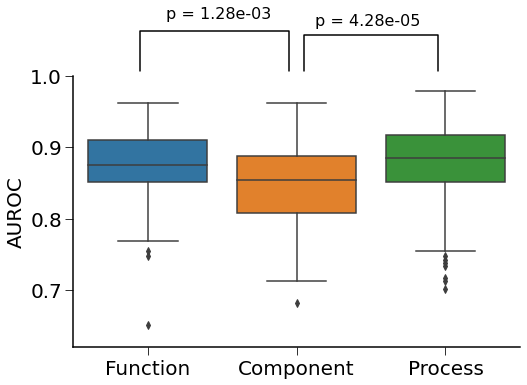

In [348]:
fig = plt.figure(figsize=(8,5))
sns.boxplot(data=auroc_df, x='category', y='auroc_p')

for ax in [plt.gca()]:
    ax.tick_params(axis='both', labelsize=20)
    ax.tick_params(which='minor', length=4)
    ax.tick_params(which='major', length=8)
    #ax.grid()
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1.5)
        ax.spines[pos].set_color('k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
ax.set_ylim([0.62,1.0])
ax.set_ylabel('AUROC', fontsize=20)
ax.set_xlabel(None)
props = {'connectionstyle':'bar','arrowstyle':'-', 'shrinkA':5,'shrinkB':5,'linewidth':1.5}

stat, p = scipy.stats.mannwhitneyu(auroc_df[auroc_df['category'] == 'Function']['auroc_p'], 
                         auroc_df[auroc_df['category'] == 'Component']['auroc_p'])
ax.annotate('', xy=(-0.05,1), xytext=(0.95,1), arrowprops=props)
ax.text(s="p = {:.2e}".format(p), x=0.475, y=1.08, zorder=10, color='k', fontsize=16, ha='center')

stat, p = scipy.stats.mannwhitneyu(auroc_df[auroc_df['category'] == 'Process']['auroc_p'], 
                         auroc_df[auroc_df['category'] == 'Component']['auroc_p'])
ax.annotate('', xy=(1.05,1), xytext=(1.95,1), arrowprops=props)
ax.text(s="p = {:.2e}".format(p), x=1.475, y=1.07, zorder=10, color='k', fontsize=16, ha='center')
plt.savefig('./img/auroc_by_category.png', bbox_inches='tight', dpi=200)

In [355]:
np.mean(auroc_df['auroc_p'])

0.8671469671124086

# Import PN for testing

In [51]:
pn_df = pd.read_csv('./proteostasis/pn_network_211212.csv')

name_to_entrez_dict = dict(zip(gene_info['symbol_ncbi'], gene_info['gene_ncbi']))

# get entrez for genes with only name
pn_df['gene_ncbi'] = pn_df['symbol_ncbi'].apply(lambda x: name_to_entrez_dict.get(x))

# drop those still without entrez
pn_df = pn_df.dropna(subset=['gene_ncbi'])

# insert Falses
pn_df[['cytosol','endoplasmic_reticulum', 'mitochondrial', 'ubq', 'autophagy',
       'ribosomal_qc', 'canon_chaperones', 'ambiguous']] = pn_df.loc[:, ['cytosol',
       'endoplasmic_reticulum', 'mitochondrial', 'ubq', 'autophagy',
       'ribosomal_qc', 'canon_chaperones', 'ambiguous']].fillna(False)

# remove ambiguous
#pn_df = pn_df[~pn_df['ambiguous']]

# remove duplicates
pn_df = pn_df.groupby('gene_entrez').max().reset_index()

# import entrez IDs
pn_df_entrez = pd.read_csv('./proteostasis/211212_pn_as_entrez.csv')

#for ambiguous genes, label ambiguity
for gene in pn_df[pn_df['ambiguous']]['gene_entrez'].values:
    pn_df_entrez = pn_df_entrez.append(pd.DataFrame({'gene_ncbi':[gene], 'family':['ambiguous']}))
    
# unstack
pn_df = pn_df_entrez.groupby(['gene_ncbi', 'family']).size().unstack().fillna(False).astype(bool).reset_index()

In [52]:
# neat str describing pn_role
pn_df['pn_role'] = ''

for index, row in pn_df.iterrows():
    
    pn_role = ''
    if row['canonical chaperones']:
        if row['ambiguous']:
            pn_role = pn_role + 'contains TPR domain, '
        else:
            pn_role = pn_role + 'canon chaperone, '
    if row['endoplasmic reticulum']:
        pn_role = pn_role + 'ER, '
    if row['mitochondrial']:
        pn_role = pn_role + 'mitochondria, '
    if row['ubiquitin proteaosome']:
        pn_role = pn_role + 'ubiquitin proteaosome, '
    if row['autophagy']:
        pn_role = pn_role + 'autophagy, '
    if row['ribosomal QC']:
        pn_role = pn_role + 'ribosome QC, '
        
    if np.sum(row[pn_df.columns[:-1]]) > 0:
        pn_role = pn_role[:-2]
        
    pn_df.loc[index, 'pn_role'] = pn_role

In [57]:
pn = set(pn_df[~(~(pn_df[['autophagy', 
              'endoplasmic reticulum', 
              'mitochondrial', 
              'ribosomal QC', 
              'ubiquitin proteaosome']].any(axis=1)) & pn_df['ambiguous'])]['gene_ncbi'].values)

# Test on PN

In [176]:
result_dict = {}

In [198]:
%%time

ontology = pn
#pn = set(pn_df['gene_ncbi'].values)
result_df = pd.DataFrame({'gene_ncbi':[], 'n_neighbors':[], 'overlap_with_ontology':[], 'in_ontology':[]})
for node in list(G.nodes):
    neighbor_set = set(G[node])
    result_df = result_df.append(pd.DataFrame({'gene_ncbi':[node], 
                                                  'n_neighbors':[len(neighbor_set)], 
                                                  'overlap_with_ontology':[len(neighbor_set & ontology)], 
                                                   'in_ontology':[bool(node in ontology)], 'n_pubs':[gene_count_dict.get(node)]}))

result_df['in_ontology'] = result_df['in_ontology'].astype(bool)
    
size_of_pn = len(set(G.nodes) & ontology)
    
    
universe_size = len(set(G.nodes))

p = 1-scipy.stats.hypergeom.cdf(M=universe_size, 
                                    N=result_df['n_neighbors'], 
                                    n=size_of_pn, k=result_df['overlap_with_ontology']-1)

result_df['p'] = p

bh_fdr = p*len(p)/(scipy.stats.rankdata(p))
bh_fdr[bh_fdr > 1.0] = 1.0 # no q-values above 1.0!

bonferroni = p*len(p)
bonferroni[bonferroni > 1.0] = 1.0

result_df['fdr'] = bh_fdr
result_df['fwer'] = bonferroni
result_df['exp_val'] = result_df['n_neighbors'] * size_of_pn / universe_size
result_df['ratio'] = result_df['overlap_with_ontology']/result_df['exp_val']
    
n = 100
prior = result_df['p'].rank(pct=True)
actual_set = result_df['in_ontology']
roc_tpr = []
roc_fpr = []
for ii in np.arange(0,1+0.5/n,1/n):
    predicted_set = np.array(prior < ii)
    tp = np.sum(predicted_set & actual_set)
    fn = np.sum((~predicted_set) & actual_set)
    tn = np.sum((~predicted_set) & (~actual_set))
    fp = np.sum((predicted_set) & (~actual_set))
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
roc_tpr = np.array(roc_tpr)
roc_fpr = np.array(roc_fpr)
auroc = auc(roc_fpr, roc_tpr)
print('AUROC (p-value): ' + str(auroc))

AUROC (p-value): 0.8791409735586018
Wall time: 27.9 s


In [199]:
result_dict['co_citation'] = {'result_df':result_df.copy(), 
                              'roc_tpr':roc_tpr, 
                              'roc_fpr':roc_fpr, 
                              'auroc':auroc, 
                              'network_ontology_size':size_of_pn, 'true_ontology_size':len(pn)}

# Import HuRI

In [294]:
huri_1 = pd.read_csv('./data/HI-union.tsv', sep='\t', header=None).rename(columns={0:'source', 1:'target'})
huri_2 = pd.read_csv('./data/Lit-BM.tsv', sep='\t', header=None).rename(columns={0:'source', 1:'target'})
huri_df = pd.concat([huri_1, huri_2])
huri_df['source_ncbi'] = huri_df['source'].apply(lambda x: ensembl_to_ncbi_dict.get(x))
huri_df['target_ncbi'] = huri_df['target'].apply(lambda x: ensembl_to_ncbi_dict.get(x))

In [297]:
huri_df

,source,target,source_ncbi,target_ncbi
0,ENSG00000000005,ENSG00000061656,64102.0,6676.0
1,ENSG00000000005,ENSG00000099968,64102.0,23786.0
2,ENSG00000000005,ENSG00000104765,64102.0,665.0
3,ENSG00000000005,ENSG00000105383,64102.0,945.0
4,ENSG00000000005,ENSG00000114455,64102.0,11148.0
...,...,...,...,...
13436,ENSG00000105185,ENSG00000172977,9141.0,10524.0
13437,ENSG00000106211,ENSG00000130402,3315.0,81.0
13438,ENSG00000106211,ENSG00000178028,3315.0,55929.0
13439,ENSG00000142208,ENSG00000150907,207.0,2308.0


In [201]:
%%time
edge_df = huri_df[['source_ncbi', 'target_ncbi']].dropna()
huri_net = nx.from_edgelist(edge_df.values)

Wall time: 478 ms


In [202]:
%%time

ontology = pn
#pn = set(pn_df['gene_ncbi'].values)
result_df = pd.DataFrame({'gene_ncbi':[], 'n_neighbors':[], 'overlap_with_ontology':[], 'in_ontology':[]})
for node in list(huri_net.nodes):
    neighbor_set = set(huri_net[node])
    result_df = result_df.append(pd.DataFrame({'gene_ncbi':[node], 
                                                  'n_neighbors':[len(neighbor_set)], 
                                                  'overlap_with_ontology':[len(neighbor_set & ontology)], 
                                                   'in_ontology':[bool(node in ontology)], 'n_pubs':[gene_count_dict.get(node)]}))

result_df['in_ontology'] = result_df['in_ontology'].astype(bool)
    
size_of_pn = len(set(huri_net.nodes) & ontology)
    
    
universe_size = len(set(huri_net.nodes))

p = 1-scipy.stats.hypergeom.cdf(M=universe_size, 
                                    N=result_df['n_neighbors'], 
                                    n=size_of_pn, k=result_df['overlap_with_ontology']-1)

result_df['p'] = p

bh_fdr = p*len(p)/(scipy.stats.rankdata(p))
bh_fdr[bh_fdr > 1.0] = 1.0 # no q-values above 1.0!

bonferroni = p*len(p)
bonferroni[bonferroni > 1.0] = 1.0

result_df['fdr'] = bh_fdr
result_df['fwer'] = bonferroni
result_df['exp_val'] = result_df['n_neighbors'] * size_of_pn / universe_size
result_df['ratio'] = result_df['overlap_with_ontology']/result_df['exp_val']
    
n = 100
prior = result_df['p'].rank(pct=True)
actual_set = result_df['in_ontology']
roc_tpr = []
roc_fpr = []
for ii in np.arange(0,1+0.5/n,1/n):
    predicted_set = np.array(prior < ii)
    tp = np.sum(predicted_set & actual_set)
    fn = np.sum((~predicted_set) & actual_set)
    tn = np.sum((~predicted_set) & (~actual_set))
    fp = np.sum((predicted_set) & (~actual_set))
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
roc_tpr = np.array(roc_tpr)
roc_fpr = np.array(roc_fpr)
auroc = auc(roc_fpr, roc_tpr)
print('AUROC (p-value): ' + str(auroc))

AUROC (p-value): 0.743227984560505
Wall time: 16.4 s


In [203]:
result_dict['huri'] = {'result_df':result_df.copy(), 
                              'roc_tpr':roc_tpr, 
                              'roc_fpr':roc_fpr, 
                              'auroc':auroc, 
                              'network_ontology_size':size_of_pn, 'true_ontology_size':len(pn)}

# Import co-essential network

In [204]:
co_ess_df = pd.read_csv('./data/co_essential_net.csv').interpolate(method='pad')
co_ess_df['Lead gene'] = co_ess_df['Lead gene'].apply(lambda x: x.rstrip('*'))

co_ess_df['gene_ncbi_0'] = co_ess_df['Lead gene name'].apply(lambda x: nomenclature_ncbi_dict.get(x))
co_ess_df['gene_ncbi_1'] = co_ess_df['Lead gene'].apply(lambda x: gene_symbol_ncbi_dict.get(x))

co_ess_df['gene_ncbi_2'] = co_ess_df['Partner gene name'].apply(lambda x: nomenclature_ncbi_dict.get(x))
co_ess_df['gene_ncbi_3'] = co_ess_df['Partner gene'].apply(lambda x: gene_symbol_ncbi_dict.get(x))

co_ess_df['source'] = co_ess_df[['gene_ncbi_0', 'gene_ncbi_1']].max(axis=1)
co_ess_df['target'] = co_ess_df[['gene_ncbi_2', 'gene_ncbi_3']].max(axis=1)

co_ess_df = co_ess_df.dropna(subset=['source', 'target'])

In [205]:
%%time
edge_df = co_ess_df[['source', 'target']].dropna()
co_ess_net = nx.from_edgelist(edge_df.values)

Wall time: 281 ms


In [206]:
%%time

ontology = pn
#pn = set(pn_df['gene_ncbi'].values)
result_df = pd.DataFrame({'gene_ncbi':[], 'n_neighbors':[], 'overlap_with_ontology':[], 'in_ontology':[]})
for node in list(co_ess_net.nodes):
    neighbor_set = set(co_ess_net[node])
    result_df = result_df.append(pd.DataFrame({'gene_ncbi':[node], 
                                                  'n_neighbors':[len(neighbor_set)], 
                                                  'overlap_with_ontology':[len(neighbor_set & ontology)], 
                                                   'in_ontology':[bool(node in ontology)], 'n_pubs':[gene_count_dict.get(node)]}))

result_df['in_ontology'] = result_df['in_ontology'].astype(bool)
    
size_of_pn = len(set(co_ess_net.nodes) & ontology)
    
    
universe_size = len(set(co_ess_net.nodes))

p = 1-scipy.stats.hypergeom.cdf(M=universe_size, 
                                    N=result_df['n_neighbors'], 
                                    n=size_of_pn, k=result_df['overlap_with_ontology']-1)

result_df['p'] = p

bh_fdr = p*len(p)/(scipy.stats.rankdata(p))
bh_fdr[bh_fdr > 1.0] = 1.0 # no q-values above 1.0!

bonferroni = p*len(p)
bonferroni[bonferroni > 1.0] = 1.0

result_df['fdr'] = bh_fdr
result_df['fwer'] = bonferroni
result_df['exp_val'] = result_df['n_neighbors'] * size_of_pn / universe_size
result_df['ratio'] = result_df['overlap_with_ontology']/result_df['exp_val']
    
n = 1000
prior = result_df['p'].rank(pct=True)
actual_set = result_df['in_ontology']
roc_tpr = []
roc_fpr = []
for ii in np.arange(0,1+0.5/n,1/n):
    predicted_set = np.array(prior < ii)
    tp = np.sum(predicted_set & actual_set)
    fn = np.sum((~predicted_set) & actual_set)
    tn = np.sum((~predicted_set) & (~actual_set))
    fp = np.sum((predicted_set) & (~actual_set))
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
roc_tpr = np.array(roc_tpr)
roc_fpr = np.array(roc_fpr)
auroc = auc(roc_fpr, roc_tpr)
print('AUROC (p-value): ' + str(auroc))

AUROC (p-value): 0.6607654472722241
Wall time: 14 s


In [207]:
result_dict['co_ess_net'] = {'result_df':result_df.copy(), 
                              'roc_tpr':roc_tpr, 
                              'roc_fpr':roc_fpr, 
                              'auroc':auroc, 
                              'network_ontology_size':size_of_pn, 'true_ontology_size':len(pn)}

In [208]:
result_dict

{'co_citation': {'result_df':      gene_ncbi  n_neighbors  overlap_with_ontology  in_ontology  n_pubs  \
  0       7157.0       2414.0                  534.0         True  9483.0   
  0       7124.0       1320.0                  229.0        False  5712.0   
  0       1956.0       1494.0                  301.0         True  5450.0   
  0       3569.0        975.0                  147.0        False  4408.0   
  0       7422.0       1126.0                  158.0        False  4479.0   
  ..         ...          ...                    ...          ...     ...   
  0   28187111.0          1.0                    0.0        False     NaN   
  0   10068459.0          1.0                    0.0        False     NaN   
  0    8226803.0          1.0                    0.0        False     NaN   
  0   24498168.0          1.0                    0.0        False     NaN   
  0   28393470.0          1.0                    0.0        False     NaN   
  
                 p           fdr          fwe

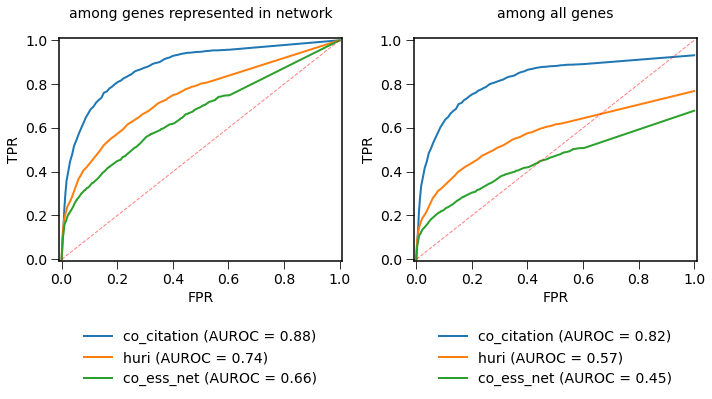

In [256]:
pad = 0.01
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

ax = axes[0]

for network in ['co_citation', 'huri', 'co_ess_net']:
    result = result_dict.get(network)
    ax.plot(result.get('roc_fpr'), 
            result.get('roc_tpr'), linewidth=2, label=network + " (AUROC = {:.2f})".format(result.get('auroc')))
    #*result.get('network_ontology_size')/result.get('true_ontology_size')

ax.set_title('among genes represented in network', fontsize=14, pad=20)
ax = axes[1]

for network in ['co_citation', 'huri', 'co_ess_net']:
    result = result_dict.get(network)
    frac = result.get('network_ontology_size')/result.get('true_ontology_size')
    ax.plot(result.get('roc_fpr'), 
            result.get('roc_tpr')*frac, linewidth=2, label=network + " (AUROC = {:.2f})".format(result.get('auroc')*frac))

ax.set_title('among all genes', fontsize=14, pad=20)

for ax in axes:
    ax.plot([0,1], [0,1], linewidth=1, alpha=0.5, color='r', linestyle='dashed')
    ax.legend(fontsize=14, frameon=False, loc='upper center', bbox_to_anchor=(0.5,-0.25))
    ax.set_xlim([0-pad,1+pad])
    ax.set_ylim([0-pad,1+pad])
    ax.set_ylabel('TPR', fontsize=14)
    ax.set_xlabel('FPR', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(which='minor', length=4)
    ax.tick_params(which='major', length=8)
    #ax.grid()
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1.5)
        ax.spines[pos].set_color('k')
        
fig.tight_layout()

# consensus model

In [287]:
result_df_co_citation = result_dict.get('co_citation').get('result_df')
result_df_huri = result_dict.get('huri').get('result_df')
result_df_co_ess_net = result_dict.get('co_ess_net').get('result_df')
result_df_array = [result_df_co_citation, result_df_huri, result_df_co_ess_net]
for df in result_df_array:
    df['prior_rank'] = df['p'].rank(pct=True)
result_df = pd.concat(result_df_array).sort_values('prior_rank').drop_duplicates(subset=['gene_ncbi'], keep='first')

n = 1000
prior = result_df['prior_rank'].rank(pct=True)
actual_set = result_df['in_ontology']
roc_tpr = []
roc_fpr = []
for ii in np.arange(0,1+0.5/n,1/n):
    predicted_set = np.array(prior < ii)
    tp = np.sum(predicted_set & actual_set)
    fn = np.sum((~predicted_set) & actual_set)
    tn = np.sum((~predicted_set) & (~actual_set))
    fp = np.sum((predicted_set) & (~actual_set))
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
roc_tpr = np.array(roc_tpr)
roc_fpr = np.array(roc_fpr)
auroc = auc(roc_fpr, roc_tpr)
print('AUROC (p-value): ' + str(auroc))

result_dict['consensus_min'] = {'result_df':result_df.copy(), 
                              'roc_tpr':roc_tpr, 
                              'roc_fpr':roc_fpr, 
                              'auroc':auroc, 
                              'network_ontology_size':np.sum(result_df['gene_ncbi'].isin(pn)), 
                             'true_ontology_size':len(pn)}

AUROC (p-value): 0.8704503420041768


In [290]:
result_df_co_citation = result_dict.get('co_citation').get('result_df')
result_df_huri = result_dict.get('huri').get('result_df')
result_df_co_ess_net = result_dict.get('co_ess_net').get('result_df')
result_df_array = [result_df_co_citation, result_df_huri, result_df_co_ess_net]
for df in result_df_array:
    df['prior_rank'] = df['p'].rank(pct=True)
result_df = pd.concat(result_df_array).sort_values('prior_rank')#.drop_duplicates(subset=['gene_ncbi'], keep='first')
result_df = result_df.groupby('gene_ncbi').median().reset_index()
result_df['in_ontology'] = result_df['in_ontology'].astype(bool)

n = 1000
prior = result_df['prior_rank'].rank(pct=True)
actual_set = result_df['in_ontology']
roc_tpr = []
roc_fpr = []
for ii in np.arange(0,1+0.5/n,1/n):
    predicted_set = np.array(prior < ii)
    tp = np.sum(predicted_set & actual_set)
    fn = np.sum((~predicted_set) & actual_set)
    tn = np.sum((~predicted_set) & (~actual_set))
    fp = np.sum((predicted_set) & (~actual_set))
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
roc_tpr = np.array(roc_tpr)
roc_fpr = np.array(roc_fpr)
auroc = auc(roc_fpr, roc_tpr)
print('AUROC (p-value): ' + str(auroc))

result_dict['consensus_median'] = {'result_df':result_df.copy(), 
                              'roc_tpr':roc_tpr, 
                              'roc_fpr':roc_fpr, 
                              'auroc':auroc, 
                              'network_ontology_size':np.sum(result_df['gene_ncbi'].isin(pn)), 
                             'true_ontology_size':len(pn)}

AUROC (p-value): 0.8450621381554355


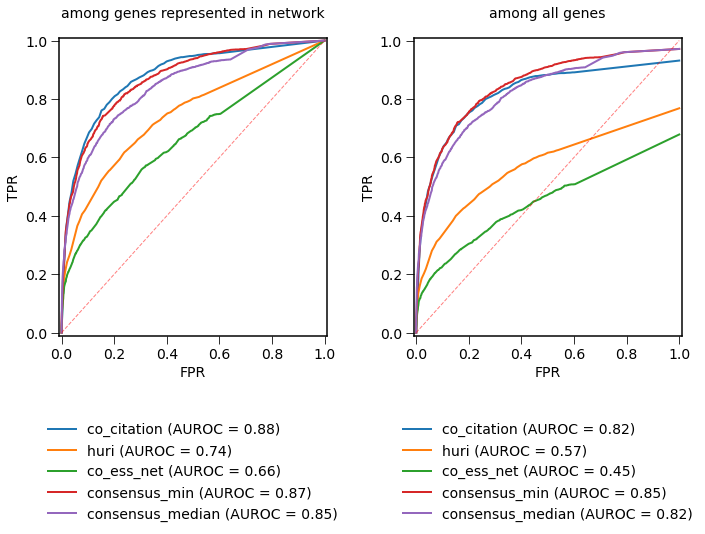

In [292]:
pad = 0.01
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,8))

ax = axes[0]

for network in ['co_citation', 'huri', 'co_ess_net', 'consensus_min', 'consensus_median']:
    result = result_dict.get(network)
    ax.plot(result.get('roc_fpr'), 
            result.get('roc_tpr'), linewidth=2, label=network + " (AUROC = {:.2f})".format(result.get('auroc')))
    #*result.get('network_ontology_size')/result.get('true_ontology_size')

ax.set_title('among genes represented in network', fontsize=14, pad=20)
ax = axes[1]

for network in ['co_citation', 'huri', 'co_ess_net', 'consensus_min', 'consensus_median']:
    result = result_dict.get(network)
    frac = result.get('network_ontology_size')/result.get('true_ontology_size')
    ax.plot(result.get('roc_fpr'), 
            result.get('roc_tpr')*frac, linewidth=2, label=network + " (AUROC = {:.2f})".format(result.get('auroc')*frac))

ax.set_title('among all genes', fontsize=14, pad=20)

for ax in axes:
    ax.plot([0,1], [0,1], linewidth=1, alpha=0.5, color='r', linestyle='dashed')
    ax.legend(fontsize=14, frameon=False, loc='upper center', bbox_to_anchor=(0.5,-0.25))
    ax.set_xlim([0-pad,1+pad])
    ax.set_ylim([0-pad,1+pad])
    ax.set_ylabel('TPR', fontsize=14)
    ax.set_xlabel('FPR', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(which='minor', length=4)
    ax.tick_params(which='major', length=8)
    #ax.grid()
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1.5)
        ax.spines[pos].set_color('k')
        
fig.tight_layout()

In [327]:
for name, network in zip(['co_cite', 'huri', 'co_ess'], [G, huri_net, co_ess_net]):
    print(name)
    print(len(network.nodes))
    print(len(network.edges))

co_cite
19354
300375
huri
11460
75420
co_ess
8948
52851


In [333]:
combo_edgelist = pd.concat([nx.to_pandas_edgelist(G)[['source', 'target']], 
          nx.to_pandas_edgelist(huri_net), 
          nx.to_pandas_edgelist(co_ess_net)])

In [348]:
%%time
combo_net = nx.from_edgelist(combo_edgelist.values)

Wall time: 1.29 s


In [349]:
%%time

ontology = pn
#pn = set(pn_df['gene_ncbi'].values)
result_df = pd.DataFrame({'gene_ncbi':[], 'n_neighbors':[], 'overlap_with_ontology':[], 'in_ontology':[]})
for node in list(combo_net.nodes):
    neighbor_set = set(combo_net[node])
    result_df = result_df.append(pd.DataFrame({'gene_ncbi':[node], 
                                                  'n_neighbors':[len(neighbor_set)], 
                                                  'overlap_with_ontology':[len(neighbor_set & ontology)], 
                                                   'in_ontology':[bool(node in ontology)], 'n_pubs':[gene_count_dict.get(node)]}))

result_df['in_ontology'] = result_df['in_ontology'].astype(bool)
    
size_of_pn = len(set(combo_net.nodes) & ontology)
    
    
universe_size = len(set(combo_net.nodes))

p = 1-scipy.stats.hypergeom.cdf(M=universe_size, 
                                    N=result_df['n_neighbors'], 
                                    n=size_of_pn, k=result_df['overlap_with_ontology']-1)

result_df['p'] = p

bh_fdr = p*len(p)/(scipy.stats.rankdata(p))
bh_fdr[bh_fdr > 1.0] = 1.0 # no q-values above 1.0!

bonferroni = p*len(p)
bonferroni[bonferroni > 1.0] = 1.0

result_df['fdr'] = bh_fdr
result_df['fwer'] = bonferroni
result_df['exp_val'] = result_df['n_neighbors'] * size_of_pn / universe_size
result_df['ratio'] = result_df['overlap_with_ontology']/result_df['exp_val']
    
n = 1000
prior = result_df['p'].rank(pct=True)
actual_set = result_df['in_ontology']
roc_tpr = []
roc_fpr = []
for ii in np.arange(0,1+0.5/n,1/n):
    predicted_set = np.array(prior < ii)
    tp = np.sum(predicted_set & actual_set)
    fn = np.sum((~predicted_set) & actual_set)
    tn = np.sum((~predicted_set) & (~actual_set))
    fp = np.sum((predicted_set) & (~actual_set))
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
roc_tpr = np.array(roc_tpr)
roc_fpr = np.array(roc_fpr)
auroc = auc(roc_fpr, roc_tpr)
print('AUROC (p-value): ' + str(auroc))

AUROC (p-value): 0.8705242267972648
Wall time: 30.8 s


In [350]:
result_dict['combo_net'] = {'result_df':result_df.copy(), 
                              'roc_tpr':roc_tpr, 
                              'roc_fpr':roc_fpr, 
                              'auroc':auroc, 
                              'network_ontology_size':size_of_pn, 'true_ontology_size':len(pn)}

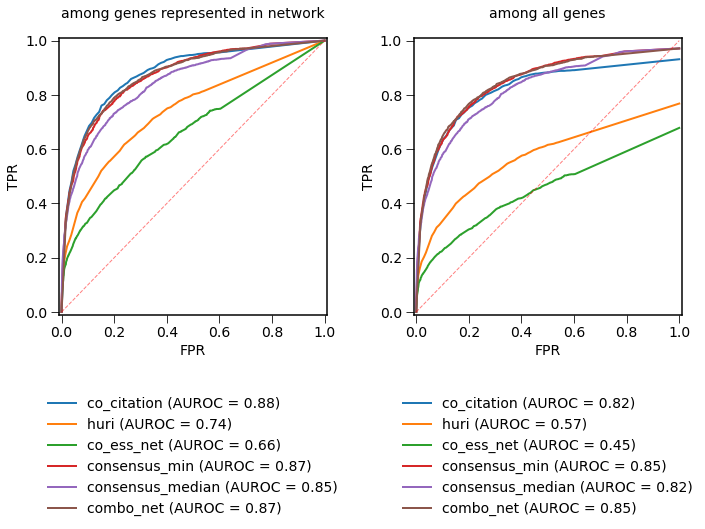

In [355]:
pad = 0.01
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,8))

ax = axes[0]

for network in ['co_citation', 'huri', 'co_ess_net', 'consensus_min', 'consensus_median', 'combo_net']:
    result = result_dict.get(network)
    ax.plot(result.get('roc_fpr'), 
            result.get('roc_tpr'), linewidth=2, label=network + " (AUROC = {:.2f})".format(result.get('auroc')))
    #*result.get('network_ontology_size')/result.get('true_ontology_size')

ax.set_title('among genes represented in network', fontsize=14, pad=20)
ax = axes[1]

for network in ['co_citation', 'huri', 'co_ess_net', 'consensus_min', 'consensus_median', 'combo_net']:
    result = result_dict.get(network)
    frac = result.get('network_ontology_size')/result.get('true_ontology_size')
    ax.plot(result.get('roc_fpr'), 
            result.get('roc_tpr')*frac, linewidth=2, label=network + " (AUROC = {:.2f})".format(result.get('auroc')*frac))

ax.set_title('among all genes', fontsize=14, pad=20)

for ax in axes:
    ax.plot([0,1], [0,1], linewidth=1, alpha=0.5, color='r', linestyle='dashed')
    ax.legend(fontsize=14, frameon=False, loc='upper center', bbox_to_anchor=(0.5,-0.25))
    ax.set_xlim([0-pad,1+pad])
    ax.set_ylim([0-pad,1+pad])
    ax.set_ylabel('TPR', fontsize=14)
    ax.set_xlabel('FPR', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(which='minor', length=4)
    ax.tick_params(which='major', length=8)
    #ax.grid()
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1.5)
        ax.spines[pos].set_color('k')
        
fig.tight_layout()

fig.savefig('./img/auroc_graphs_pn.png', dpi=200, bbox_inches='tight')

In [356]:
%%time
temporal_network = {}
for year in range(1970, 2019):
    
    gene2pubmed_new = gene2pubmed.copy()

    gene2pubmed_new = gene2pubmed_new[(gene2pubmed_new['year'] <= year)]

    valid_pubmed_ids = gene2pubmed_new['pubmed_id'].value_counts()

    valid_pubmed_ids = valid_pubmed_ids[(valid_pubmed_ids > 1) & (valid_pubmed_ids <= 10)]

    gene2pubmed_new = gene2pubmed_new[gene2pubmed_new['pubmed_id'].isin(valid_pubmed_ids.index)]

    gene_count = gene2pubmed[(gene2pubmed['year'] >= 2000) & (gene2pubmed['year'] <= 2018)]['gene_ncbi'].value_counts()

    genes_of_interest = gene_count[gene_count.index.isin(gene_info['gene_ncbi'])].index.values

    edge_df = gene2pubmed_new[gene2pubmed_new['gene_ncbi'].isin(genes_of_interest)][['gene_ncbi', 'pubmed_id']]
    G = nx.from_edgelist(edge_df.values)

    len(edge_df['gene_ncbi'].value_counts().index.values)

    B_unweighted = nx.algorithms.bipartite.projected_graph(G, nodes=edge_df['gene_ncbi'].value_counts().index.values)
    
    temporal_network[year] = B_unweighted
    print(year)

1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
Wall time: 1min 12s


In [357]:
%%time
result_dict = {}
for year in range(1970, 2019):
    net = temporal_network.get(year)
    ontology = pn
    #pn = set(pn_df['gene_ncbi'].values)
    result_df = pd.DataFrame({'gene_ncbi':[], 'n_neighbors':[], 'overlap_with_ontology':[], 'in_ontology':[]})
    for node in list(net.nodes):
        neighbor_set = set(net[node])
        result_df = result_df.append(pd.DataFrame({'gene_ncbi':[node], 
                                                      'n_neighbors':[len(neighbor_set)], 
                                                      'overlap_with_ontology':[len(neighbor_set & ontology)], 
                                                       'in_ontology':[bool(node in ontology)], 'n_pubs':[gene_count_dict.get(node)]}))

    result_df['in_ontology'] = result_df['in_ontology'].astype(bool)

    size_of_pn = len(set(net.nodes) & ontology)


    universe_size = len(set(net.nodes))

    p = 1-scipy.stats.hypergeom.cdf(M=universe_size, 
                                        N=result_df['n_neighbors'], 
                                        n=size_of_pn, k=result_df['overlap_with_ontology']-1)

    result_df['p'] = p

    bh_fdr = p*len(p)/(scipy.stats.rankdata(p))
    bh_fdr[bh_fdr > 1.0] = 1.0 # no q-values above 1.0!

    bonferroni = p*len(p)
    bonferroni[bonferroni > 1.0] = 1.0

    result_df['fdr'] = bh_fdr
    result_df['fwer'] = bonferroni
    result_df['exp_val'] = result_df['n_neighbors'] * size_of_pn / universe_size
    result_df['ratio'] = result_df['overlap_with_ontology']/result_df['exp_val']

    n = 1000
    prior = result_df['p'].rank(pct=True)
    actual_set = result_df['in_ontology']
    roc_tpr = []
    roc_fpr = []
    for ii in np.arange(0,1+0.5/n,1/n):
        predicted_set = np.array(prior < ii)
        tp = np.sum(predicted_set & actual_set)
        fn = np.sum((~predicted_set) & actual_set)
        tn = np.sum((~predicted_set) & (~actual_set))
        fp = np.sum((predicted_set) & (~actual_set))
        tpr = tp/(tp + fn)
        fpr = fp/(fp + tn)
        roc_tpr.append(tpr)
        roc_fpr.append(fpr)
    roc_tpr = np.array(roc_tpr)
    roc_fpr = np.array(roc_fpr)
    auroc = auc(roc_fpr, roc_tpr)
    print(year)
    print('AUROC (p-value): ' + str(auroc))
    result_dict[year] = {'result_df':result_df.copy(), 
                              'roc_tpr':roc_tpr, 
                              'roc_fpr':roc_fpr, 
                              'auroc':auroc, 
                              'network_ontology_size':size_of_pn, 'true_ontology_size':len(pn)}

1970
AUROC (p-value): 0.8177083333333333
1971
AUROC (p-value): 0.8208333333333332
1972
AUROC (p-value): 0.7307692307692307
1973
AUROC (p-value): 0.7348484848484849
1974
AUROC (p-value): 0.6817073170731707
1975
AUROC (p-value): 0.7214912280701754
1976
AUROC (p-value): 0.7476539589442814
1977
AUROC (p-value): 0.7518716577540107
1978
AUROC (p-value): 0.7584126984126984
1979
AUROC (p-value): 0.7542067307692307
1980
AUROC (p-value): 0.7559812235009085
1981
AUROC (p-value): 0.7486080852093924
1982
AUROC (p-value): 0.752991452991453
1983
AUROC (p-value): 0.7175542547115934
1984
AUROC (p-value): 0.7299019607843137
1985
AUROC (p-value): 0.7583894801939914
1986
AUROC (p-value): 0.7339850298694246
1987
AUROC (p-value): 0.727470469605301
1988
AUROC (p-value): 0.7418103647542879
1989
AUROC (p-value): 0.7292342985759426
1990
AUROC (p-value): 0.7633593848108559
1991
AUROC (p-value): 0.77741480445571
1992
AUROC (p-value): 0.7855930500807082
1993
AUROC (p-value): 0.77149316902687
1994
AUROC (p-value): 

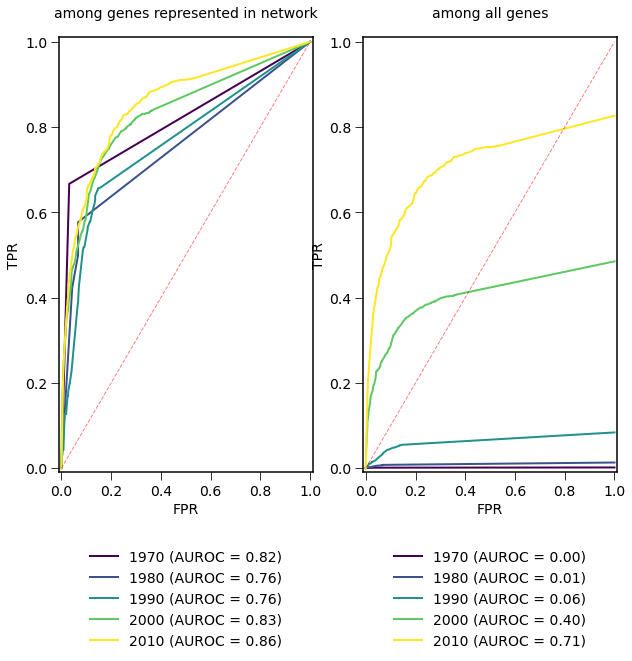

In [394]:
pad = 0.01
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,8))

years = range(1970, 2019, 10)
cmap = mpl.cm.get_cmap('viridis', len(years))

for year, ii in zip(years, range(len(years))):
    result = result_dict.get(year)
    frac = result.get('network_ontology_size')/result.get('true_ontology_size')
    axes[0].plot(result.get('roc_fpr'), 
            result.get('roc_tpr'), 
            linewidth=2, 
            label=str(year) + " (AUROC = {:.2f})".format(result.get('auroc')), color=cmap(ii))
    axes[1].plot(result.get('roc_fpr'), 
            result.get('roc_tpr')*frac, 
            linewidth=2, 
            label=str(year) + " (AUROC = {:.2f})".format(result.get('auroc')*frac), color=cmap(ii))

axes[0].set_title('among genes represented in network', fontsize=14, pad=20)
axes[1].set_title('among all genes', fontsize=14, pad=20)

for ax in axes:
    ax.plot([0,1], [0,1], linewidth=1, alpha=0.5, color='r', linestyle='dashed')
    ax.legend(fontsize=14, frameon=False, loc='upper center', bbox_to_anchor=(0.5,-0.15))
    ax.set_xlim([0-pad,1+pad])
    ax.set_ylim([0-pad,1+pad])
    ax.set_ylabel('TPR', fontsize=14)
    ax.set_xlabel('FPR', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(which='minor', length=4)
    ax.tick_params(which='major', length=8)
    #ax.grid()
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1.5)
        ax.spines[pos].set_color('k')
        
#fig.tight_layout()

In [360]:
cmap = mpl.cm.get_cmap('seismic', 2019-1970)

In [365]:
cmap(2)

(0.0, 0.0, 0.41666666666666663, 1.0)

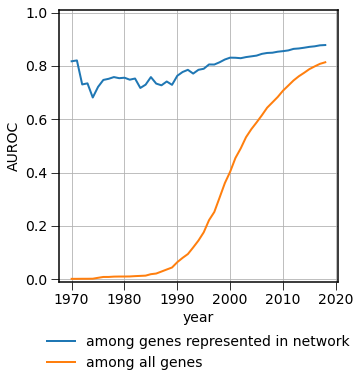

In [395]:
pad = 0.01
years = range(1970, 2019, 1)
aurocs_1 = [result_dict.get(year).get('auroc') for year in years]
aurocs_2 = [result_dict.get(year).get('auroc')*result_dict.get(year).get('network_ontology_size')/
            result_dict.get(year).get('true_ontology_size') for year in years]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.plot(years, aurocs_1, linewidth=2, label='among genes represented in network')
ax.plot(years, aurocs_2, linewidth=2, label='among all genes')

for ax in [ax]:
    #ax.plot([0,1], [0,1], linewidth=1, alpha=0.5, color='r', linestyle='dashed')
    ax.legend(fontsize=14, frameon=False, loc='upper center', bbox_to_anchor=(0.5,-0.15))
    #ax.set_xlim([0-pad,1+pad])
    ax.grid()
    ax.set_ylim([0-pad,1+pad])
    ax.set_ylabel('AUROC', fontsize=14)
    ax.set_xlabel('year', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(which='minor', length=4)
    ax.tick_params(which='major', length=8)
    #ax.grid()
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1.5)
        ax.spines[pos].set_color('k')
        
fig.savefig('./img/auroc_over_time_pn.png', dpi=200, bbox_inches='tight')

In [411]:
nx.algorithms.community.modularity(G, communities=[G.nodes & pn, G.nodes - pn])

0.06433010849635082

In [436]:
%%time
size = []
modularity = []
go_list = gene2go['go_id'].value_counts()[0:4000].index.values
go_list = np.random.choice(go_list, 100)
number_of_terms = 100 #len(go_list)

for go_id, ii in zip(go_list[0:number_of_terms], range(number_of_terms)):
    ontology = set(gene2go[gene2go['go_id'] == go_id]['gene_ncbi'].value_counts().index.values)
    size.append(len(ontology))
    modularity.append(nx.algorithms.community.modularity(G, communities=[G.nodes & ontology, G.nodes - ontology]))

Wall time: 50.8 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


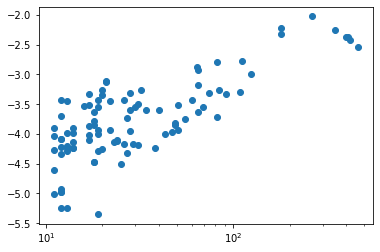

In [443]:
plt.scatter(size, np.log10(np.array(modularity)))
plt.xscale('log')
#plt.yscale('log')

In [439]:
min(modularity)

-2.8434625601822183e-05

In [440]:
modularity_null = []
for trial in range(100):
    ontology = np.random.choice(G.nodes, 10)
    modularity_null.append(nx.algorithms.community.modularity(G, communities=[G.nodes & ontology, G.nodes - ontology]))

<AxesSubplot:>

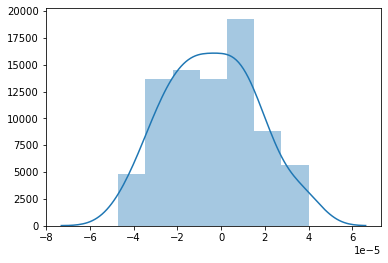

In [431]:
sns.distplot(modularity_null)

# Ideas:

* Membership based on neighborhood enrichment with dominating set of GO term?
* Membership based on neigborhood enrichment of bibliograph(n_pubs >= k) for k in 1,2,3,etc.
* USE MSIGDB

In [484]:
nx.is_connected(G)

False